## Predicting "Driver At Fault"

The business question we want to explore with this dataset is a classification prediction in which we want to predict the "Driver At Fault" as the output of our final prediction task.

This prediction task can provide valuable insights for several reasons:

- **Safety Interventions**: Understanding the factors that contribute to a driver being at fault can help in designing targeted interventions to improve driver behavior and reduce accidents.

- **Insurance and Legal Implications**: This analysis could be useful for insurance companies in assessing risk and liability in accidents. It could also assist in legal settings where determining fault is necessary.

## Import Python Packages and Load Dataset

In [ ]:
#Python Packages
import pandas as pd
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns; sns.set()

from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, classification_report
from sklearn.model_selection import GridSearchCV

In [ ]:
#Link to Google Account
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
#Import and run the dataset
data = pd.read_csv('/content/drive/MyDrive/BA476 Team Project/Raw Data.csv')
data.head()

<ipython-input-129-267b24981277>:2: DtypeWarning: Columns (1) have mixed types. Specify dtype option on import or set low_memory=False.
  data = pd.read_csv('/content/drive/MyDrive/BA476 Team Project/Raw Data.csv')


,Report Number,Local Case Number,Agency Name,ACRS Report Type,Crash Date/Time,Route Type,Road Name,Cross-Street Type,Cross-Street Name,Off-Road Description,...,Speed Limit,Driverless Vehicle,Parked Vehicle,Vehicle Year,Vehicle Make,Vehicle Model,Equipment Problems,Latitude,Longitude,Location
0,MCP3040003N,190026050,Montgomery County Police,Property Damage Crash,05/31/2019 03:00:00 PM,NaN,NaN,NaN,NaN,PARKING LOT OF 3215 SPARTAN RD,...,15,No,No,2004,HONDA,TK,UNKNOWN,39.150044,-77.063089,"(39.15004368, -77.06308884)"
1,EJ78850038,230034791,Gaithersburg Police Depar,Property Damage Crash,07/21/2023 05:59:00 PM,Maryland (State),FREDERICK RD,Unknown,WATKINS MILL RD,NaN,...,40,No,No,2011,GMC,TK,NO MISUSE,39.159264,-77.219025,"(39.1592635, -77.21902483)"
2,MCP2009002G,230034583,Montgomery County Police,Property Damage Crash,07/20/2023 03:10:00 PM,Maryland (State),GEORGIA AVE,Maryland (State),NORBECK RD,NaN,...,35,No,No,2019,FORD,F150,NO MISUSE,39.109535,-77.075806,"(39.10953506, -77.07580619)"
3,MCP3201004C,230035036,Montgomery County Police,Property Damage Crash,07/23/2023 12:10:00 PM,County,CRYSTAL ROCK DR,County,WATERS LANDING DR,NaN,...,40,No,No,2016,KIA,SW,NO MISUSE,39.190149,-77.266766,"(39.19014917, -77.26676583)"
4,MCP23290028,230035152,Montgomery County Police,Property Damage Crash,07/24/2023 06:10:00 AM,County,MONTGOMERY VILLAGE AVE,County,CENTERWAY RD,NaN,...,35,No,No,2016,TOYT,TK,NO MISUSE,39.172558,-77.203745,"(39.17255801, -77.20374546)"


In [ ]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 172105 entries, 0 to 172104
Data columns (total 43 columns):
 #   Column                          Non-Null Count   Dtype  
---  ------                          --------------   -----  
 0   Report Number                   172105 non-null  object 
 1   Local Case Number               172105 non-null  object 
 2   Agency Name                     172105 non-null  object 
 3   ACRS Report Type                172105 non-null  object 
 4   Crash Date/Time                 172105 non-null  object 
 5   Route Type                      155132 non-null  object 
 6   Road Name                       156168 non-null  object 
 7   Cross-Street Type               155099 non-null  object 
 8   Cross-Street Name               156154 non-null  object 
 9   Off-Road Description            15935 non-null   object 
 10  Municipality                    19126 non-null   object 
 11  Related Non-Motorist            5463 non-null    object 
 12  Collision Type  

## Data Preprocessing

In [ ]:
#Drop useless columns
columns_to_drop = ['Report Number','Crash Date/Time','Local Case Number','Agency Name','Route Type', 'Road Name','Cross-Street Type',
                   'Cross-Street Name', 'Off-Road Description','Municipality','Related Non-Motorist','Injury Severity',
                   'Driver Substance Abuse', 'Non-Motorist Substance Abuse', 'Person ID','Vehicle Continuing Dir', 'Vehicle Going Dir',
                   'Driverless Vehicle','Drivers License State', 'Latitude','Longitude', 'Location', 'Vehicle ID', 'Vehicle Make', 'Vehicle Model']
df_clean = data.drop(columns=columns_to_drop, axis=1)
df_clean = df_clean.dropna()

In [ ]:
#Drop useless entries and entries with missing values
df_clean = df_clean[df_clean['ACRS Report Type'] != 'Fatal Crash']
text_to_exclude = 'UNKNOWN'
condition = (df_clean == text_to_exclude).any(axis=1)
df_clean = df_clean.loc[~condition]

text_to_exclude2 = 'Unknown'
condition = (df_clean == text_to_exclude2).any(axis=1)
df_clean = df_clean.loc[~condition]

In [ ]:
#Logical Grouping
df_clean['Collision Type']=df_clean['Collision Type'].replace(['OTHER', 'HEAD ON', 'SAME DIRECTION LEFT TURN', 'SAME DIRECTION RIGHT TURN',
                                    'ANGLE MEETS LEFT TURN', 'OPPOSITE DIRECTION SIDESWIPE', 'ANGLE MEETS RIGHT TURN',
                                    'SAME DIR REND LEFT TURN', 'ANGLE MEETS LEFT HEAD ON', 'SAME DIR REND RIGHT TURN',
                                    'SAME DIR BOTH LEFT TURN', 'OPPOSITE DIR BOTH LEFT TURN'], 'OTHER')

df_clean['Weather']=df_clean['Weather'].replace(['SNOW', 'FOGGY', 'WINTRY MIX', 'OTHER', 'SLEET', 'BLOWING SNOW', 'SEVERE WINDS',
                                    'BLOWING SAND, SOIL, DIRT'], 'OTHER')

df_clean['Surface Condition']=df_clean['Surface Condition'].replace(['ICE', 'SNOW', 'SLUSH', 'OTHER', 'WATER(STANDING/MOVING)', 'OIL',
                                    'MUD, DIRT, GRAVEL'], 'OTHER')

df_clean['Light']=df_clean['Light'].replace(['DARK NO LIGHTS', 'DAWN', 'DUSK', 'DARK -- UNKNOWN LIGHTING', 'OTHER',], 'DARK/OTHER')

df_clean['Traffic Control']=df_clean['Traffic Control'].replace(['FLASHING TRAFFIC SIGNAL', 'OTHER', 'YIELD SIGN', 'PERSON', 'WARNING SIGN',
                                                                 'RAILWAY CROSSING DEVICE', 'SCHOOL ZONE SIGN DEVICE'], 'OTHER')

df_clean['Circumstance'] = df_clean['Circumstance'].where(df_clean['Circumstance'].isin(['RAIN, SNOW, WET', 'N/A, WET']), 'OTHER')

df_clean['Driver Distracted By'] = df_clean['Driver Distracted By'].where(df_clean['Driver Distracted By'].isin(['NOT DISTRACTED', 'LOOKED BUT DID NOT SEE']),
                                                                          'OTHER')

df_clean['Vehicle First Impact Location']=df_clean['Vehicle First Impact Location'].replace(['TWELVE OCLOCK'], 'FRONT')
df_clean['Vehicle First Impact Location']=df_clean['Vehicle First Impact Location'].replace(['SIX OCLOCK'], 'BACK')
df_clean['Vehicle First Impact Location']=df_clean['Vehicle First Impact Location'].replace(['ONE OCLOCK', 'TWO OCLOCK', 'THREE OCLOCK', 'FOUR OCLOCK',
                                                                                             'FIVE OCLOCK'], 'RIGHT SIDE')
df_clean['Vehicle First Impact Location']=df_clean['Vehicle First Impact Location'].replace(['SEVEN OCLOCK', 'EIGHT OCLOCK', 'NINE OCLOCK', 'TEN OCLOCK',
                                                                                             'ELEVEN OCLOCK'], 'LEFT SIDE')
df_clean['Vehicle First Impact Location']=df_clean['Vehicle First Impact Location'].replace(['UNDERSIDE', 'NON-COLLISION', 'ROOF TOP'], 'OTHER')

df_clean['Vehicle Second Impact Location']=df_clean['Vehicle Second Impact Location'].replace(['TWELVE OCLOCK'], 'FRONT')
df_clean['Vehicle Second Impact Location']=df_clean['Vehicle Second Impact Location'].replace(['SIX OCLOCK'], 'BACK')
df_clean['Vehicle Second Impact Location']=df_clean['Vehicle Second Impact Location'].replace(['ONE OCLOCK', 'TWO OCLOCK', 'THREE OCLOCK', 'FOUR OCLOCK',
                                                                                             'FIVE OCLOCK'], 'RIGHT SIDE')
df_clean['Vehicle Second Impact Location']=df_clean['Vehicle Second Impact Location'].replace(['SEVEN OCLOCK', 'EIGHT OCLOCK', 'NINE OCLOCK', 'TEN OCLOCK',
                                                                                             'ELEVEN OCLOCK'], 'LEFT SIDE')
df_clean['Vehicle Second Impact Location']=df_clean['Vehicle Second Impact Location'].replace(['UNDERSIDE', 'NON-COLLISION', 'ROOF TOP'], 'OTHER')

df_clean['Vehicle Body Type'] = df_clean['Vehicle Body Type'].where(df_clean['Vehicle Body Type'].isin(['PASSENGER CAR']), 'OTHER')

df_clean['Vehicle Movement'] = df_clean['Vehicle Movement'].where(df_clean['Vehicle Movement'].isin(['MOVING CONSTANT SPEED', 'SLOWING OR STOPPING',
                                                                                                     'STOPPED IN TRAFFIC LANE', 'MAKING LEFT TURN',
                                                                                                     'ACCELERATING', 'STARTING FROM LANE',
                                                                                                     'MAKING RIGHT TURN', 'CHANGING LANES', 'SKIDDING']), 'OTHER')


## Descriptive Analysis

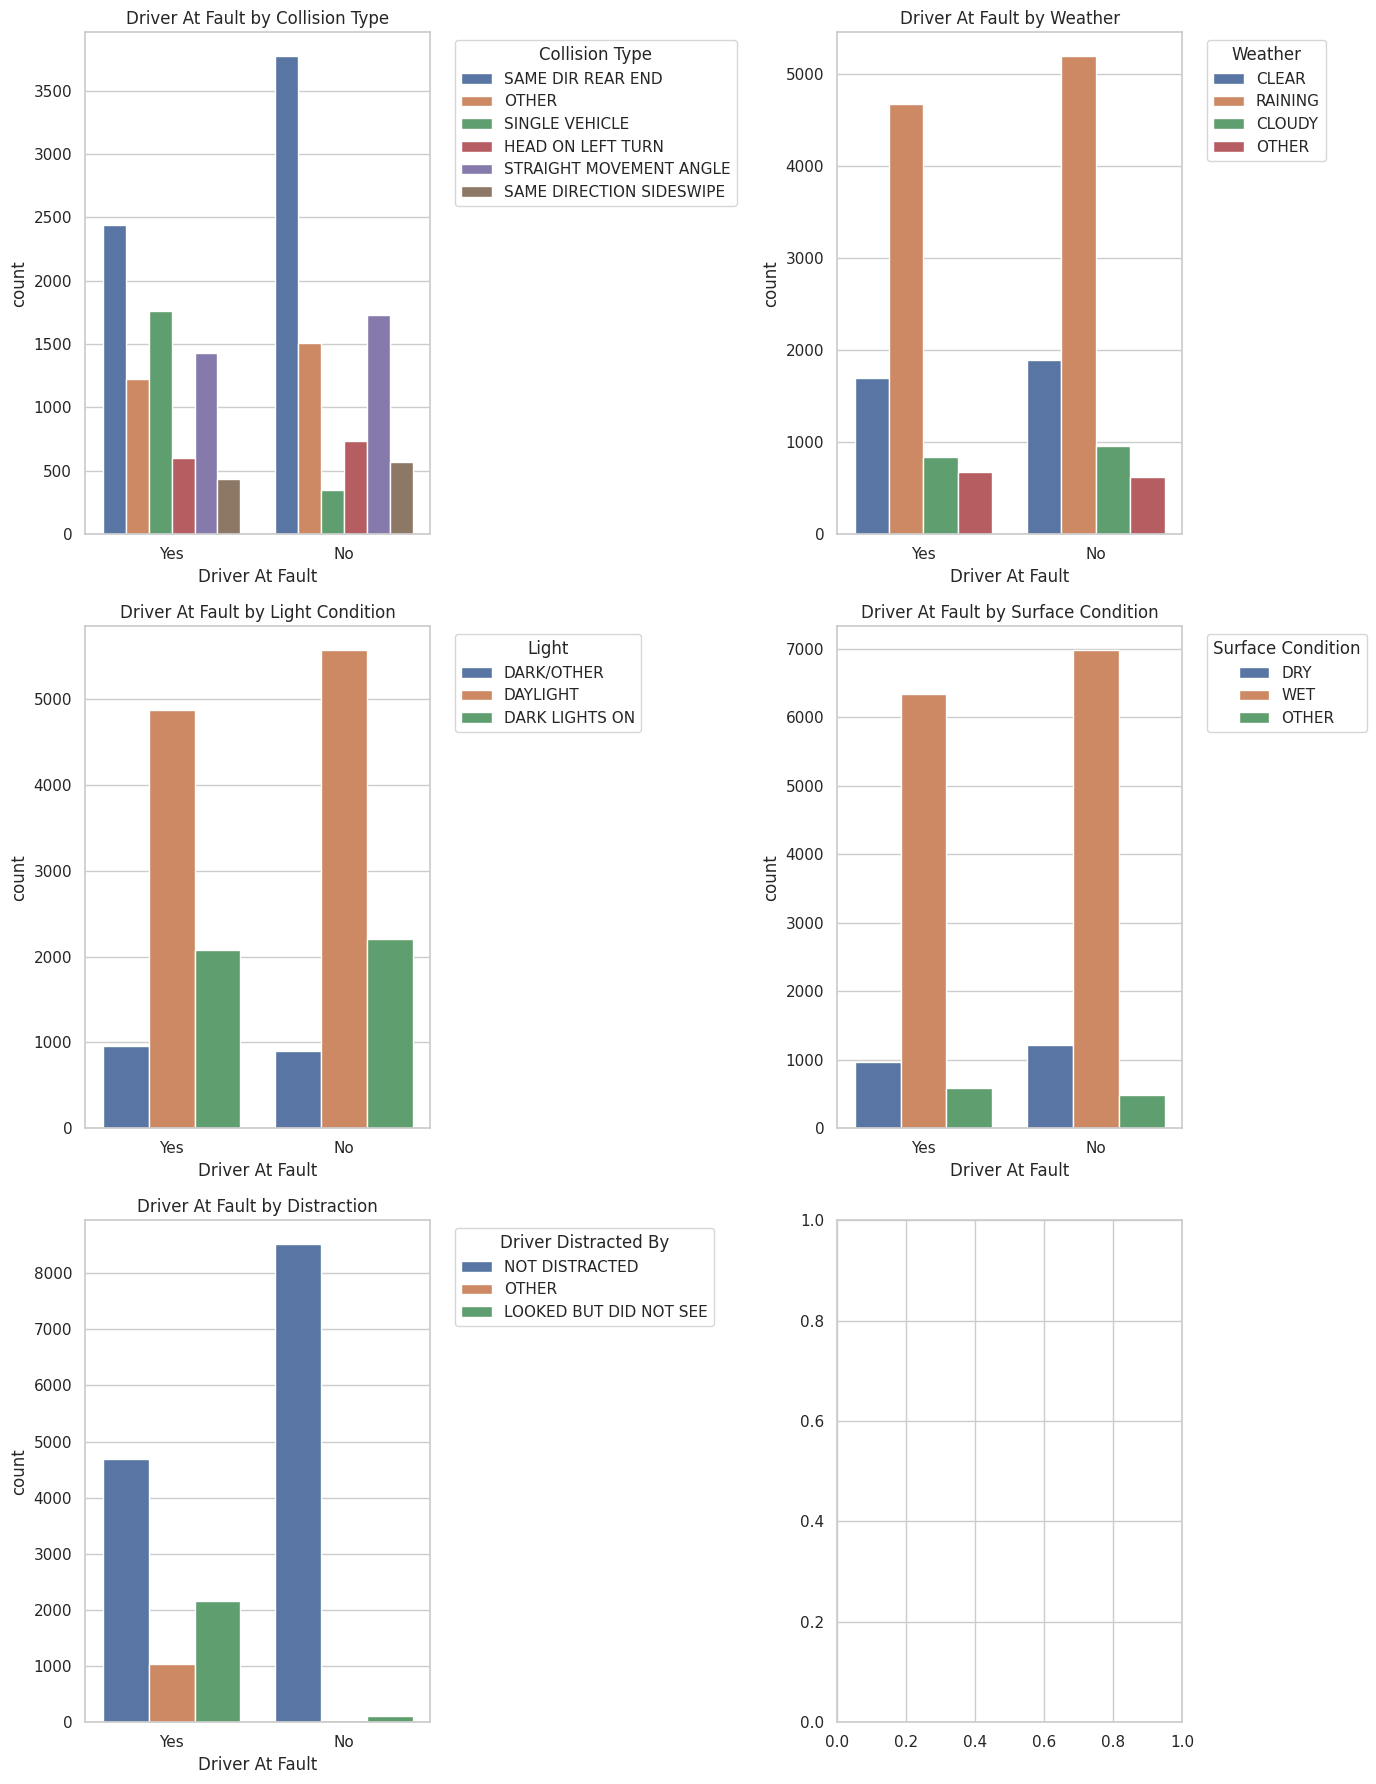

In [ ]:

sns.set(style="whitegrid")

fig, axes = plt.subplots(3, 2, figsize=(14, 18))

# Plotting different aspects to see how they correlate with the driver being at fault
sns.countplot(data=df_clean, x='Driver At Fault', hue='Collision Type', ax=axes[0, 0])
axes[0, 0].set_title('Driver At Fault by Collision Type')
axes[0, 0].legend(title='Collision Type', bbox_to_anchor=(1.05, 1), loc='upper left')

sns.countplot(data=df_clean, x='Driver At Fault', hue='Weather', ax=axes[0, 1])
axes[0, 1].set_title('Driver At Fault by Weather')
axes[0, 1].legend(title='Weather', bbox_to_anchor=(1.05, 1), loc='upper left')

sns.countplot(data=df_clean, x='Driver At Fault', hue='Light', ax=axes[1, 0])
axes[1, 0].set_title('Driver At Fault by Light Condition')
axes[1, 0].legend(title='Light', bbox_to_anchor=(1.05, 1), loc='upper left')

sns.countplot(data=df_clean, x='Driver At Fault', hue='Surface Condition', ax=axes[1, 1])
axes[1, 1].set_title('Driver At Fault by Surface Condition')
axes[1, 1].legend(title='Surface Condition', bbox_to_anchor=(1.05, 1), loc='upper left')

sns.countplot(data=df_clean, x='Driver At Fault', hue='Driver Distracted By', ax=axes[2, 0])
axes[2, 0].set_title('Driver At Fault by Distraction')
axes[2, 0].legend(title='Driver Distracted By', bbox_to_anchor=(1.05, 1), loc='upper left')

plt.tight_layout()
plt.show()


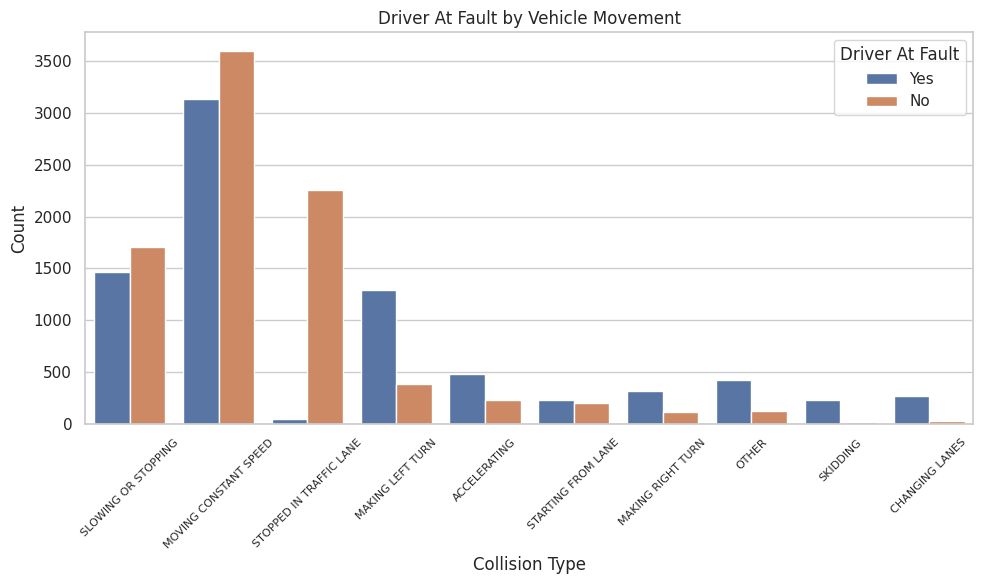

In [ ]:

plt.figure(figsize=(10, 6))

# Plotting 'Collision Type' vs 'Driver At Fault'
sns.countplot(data=df_clean, x='Vehicle Movement', hue='Driver At Fault')
plt.title('Driver At Fault by Vehicle Movement')
plt.xlabel('Collision Type')
plt.ylabel('Count')
plt.legend(title='Driver At Fault')
plt.xticks(rotation=45, fontsize=8)

# Show the plot
plt.tight_layout()
plt.show()



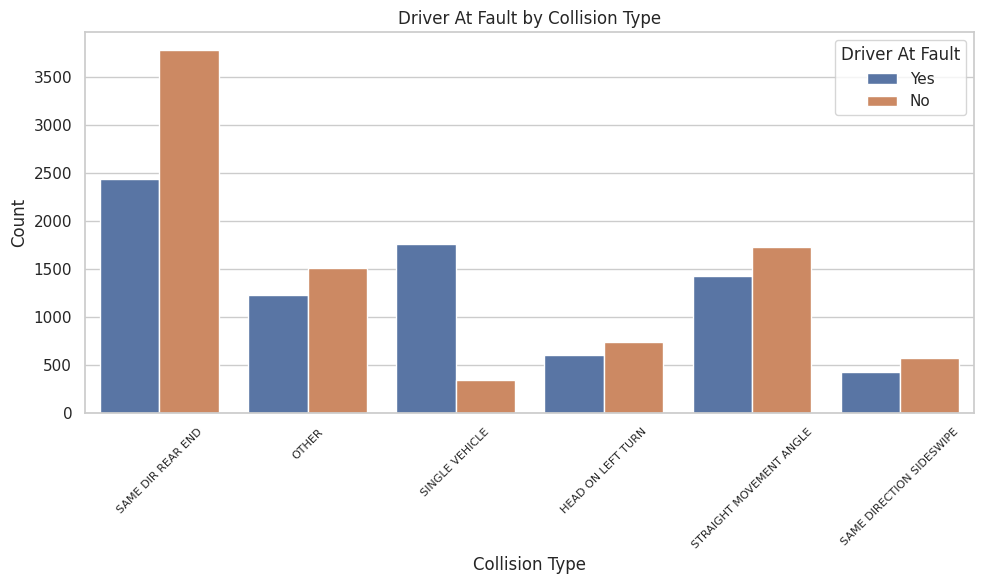

In [ ]:
plt.figure(figsize=(10, 6))

# Plotting 'Collision Type' vs 'Driver At Fault'
sns.countplot(data=df_clean, x='Collision Type', hue='Driver At Fault')
plt.title('Driver At Fault by Collision Type')
plt.xlabel('Collision Type')
plt.ylabel('Count')
plt.legend(title='Driver At Fault')
plt.xticks(rotation=45, fontsize=8)

# Show the plot
plt.tight_layout()
plt.show()



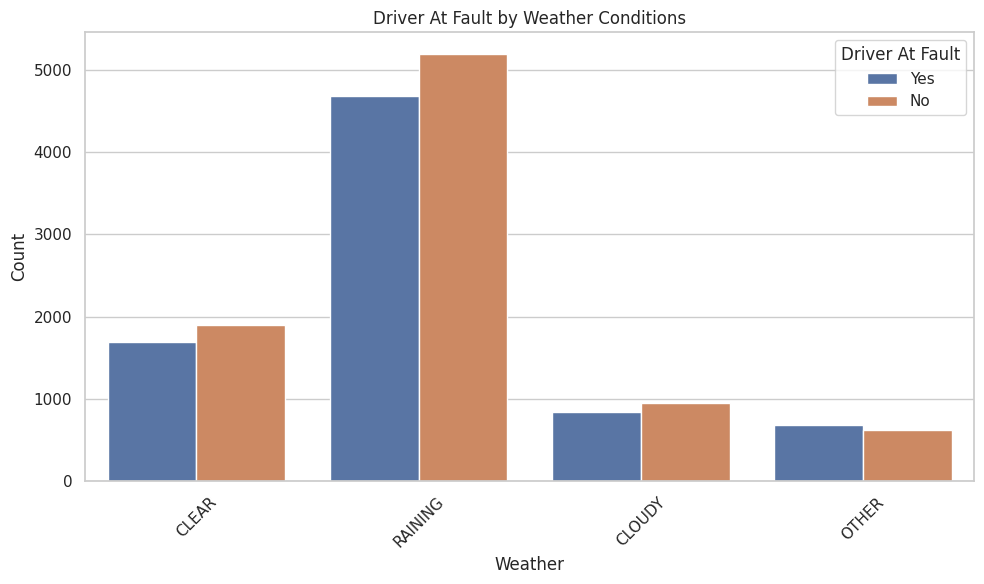

In [ ]:
plt.figure(figsize=(10, 6))

# Plotting 'Collision Type' vs 'Driver At Fault'
sns.countplot(data=df_clean, x='Weather', hue='Driver At Fault')
plt.title('Driver At Fault by Weather Conditions')
plt.xlabel('Weather')
plt.ylabel('Count')
plt.legend(title='Driver At Fault')
plt.xticks(rotation=45)

# Show the plot
plt.tight_layout()
plt.show()


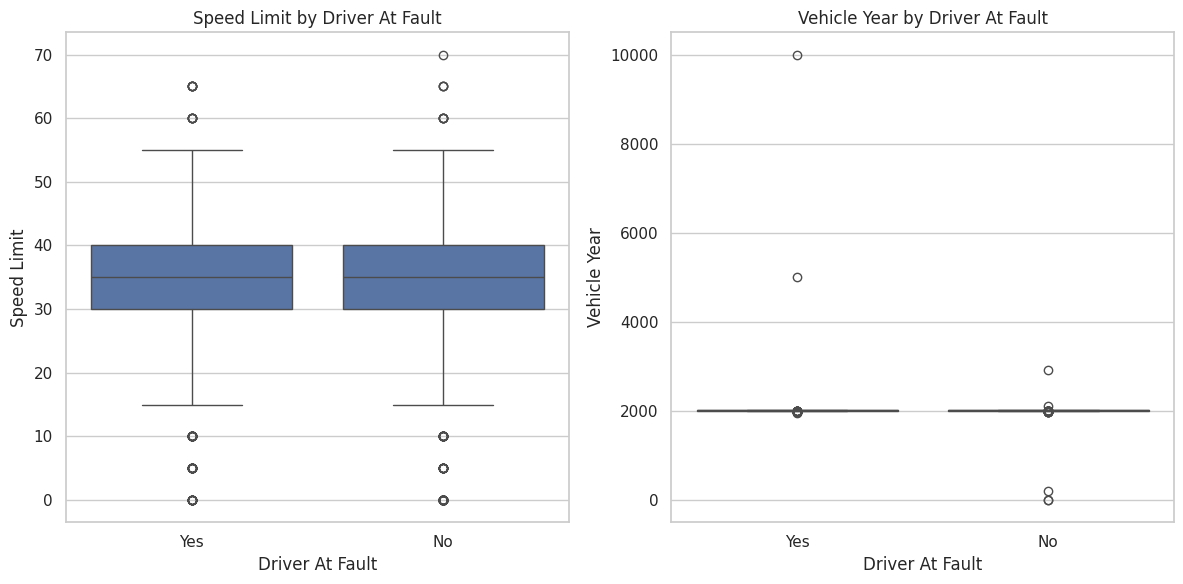

In [ ]:
# Plotting the relationship between numerical variables and 'Driver At Fault'
numerical_vars = ['Speed Limit', 'Vehicle Year']

def plot_numerical_relationships(df_clean, numerical_vars, target):
    fig, axes = plt.subplots(nrows=1, ncols=len(numerical_vars), figsize=(12, 6))

    for var, ax in zip(numerical_vars, axes):
        sns.boxplot(x=target, y=var, data=df_clean, ax=ax)
        ax.set_title(f"{var} by {target}")
        ax.set_ylabel(var)
        ax.set_xlabel(target)

    plt.tight_layout()
    plt.show()

plot_numerical_relationships(df_clean, numerical_vars, 'Driver At Fault')

## Modeling Preparation

In [ ]:
#Feature engineering

#df_clean['Severe Weather'] = df_clean['Weather Severity'].apply(lambda x: 1 if x >= 2 else 0)
#current_year = pd.to_datetime('today').year
#df_clean['Vehicle Age'] = current_year - df_clean['Vehicle Year']


In [ ]:
#One-hot encoding

df_clean['ACRS Report Type']=df_clean['ACRS Report Type'].astype('category').cat.codes
df_clean['Collision Type']=df_clean['Collision Type'].astype('category').cat.codes
df_clean['Light']=df_clean['Light'].astype('category').cat.codes
df_clean['Traffic Control']=df_clean['Traffic Control'].astype('category').cat.codes
df_clean['Circumstance']=df_clean['Circumstance'].astype('category').cat.codes
df_clean['Driver Distracted By']=df_clean['Driver Distracted By'].astype('category').cat.codes
df_clean['Vehicle Damage Extent']=df_clean['Vehicle Damage Extent'].astype('category').cat.codes
df_clean['Vehicle First Impact Location']=df_clean['Vehicle First Impact Location'].astype('category').cat.codes
df_clean['Vehicle Second Impact Location']=df_clean['Vehicle Second Impact Location'].astype('category').cat.codes
df_clean['Vehicle Body Type']=df_clean['Vehicle Body Type'].astype('category').cat.codes
df_clean['Vehicle Movement']=df_clean['Vehicle Movement'].astype('category').cat.codes
df_clean['Parked Vehicle']=df_clean['Parked Vehicle'].astype('category').cat.codes
df_clean['Equipment Problems']=df_clean['Equipment Problems'].astype('category').cat.codes
df_clean['Weather']=df_clean['Weather'].astype('category').cat.codes
df_clean['Surface Condition']=df_clean['Surface Condition'].astype('category').cat.codes

In [ ]:
#Split to train&test dataset (80/20)
from sklearn.model_selection import train_test_split, GridSearchCV

X = df_clean.drop('Driver At Fault', axis=1)
y = df_clean['Driver At Fault'].apply(lambda x: 1 if x == 'Yes' else 0)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [ ]:
X_train.info()

<class 'pandas.core.frame.DataFrame'>
Index: 13252 entries, 152044 to 164297
Data columns (total 17 columns):
 #   Column                          Non-Null Count  Dtype
---  ------                          --------------  -----
 0   ACRS Report Type                13252 non-null  int8 
 1   Collision Type                  13252 non-null  int8 
 2   Weather                         13252 non-null  int8 
 3   Surface Condition               13252 non-null  int8 
 4   Light                           13252 non-null  int8 
 5   Traffic Control                 13252 non-null  int8 
 6   Circumstance                    13252 non-null  int8 
 7   Driver Distracted By            13252 non-null  int8 
 8   Vehicle Damage Extent           13252 non-null  int8 
 9   Vehicle First Impact Location   13252 non-null  int8 
 10  Vehicle Second Impact Location  13252 non-null  int8 
 11  Vehicle Body Type               13252 non-null  int8 
 12  Vehicle Movement                13252 non-null  int8 
 13  

## Model 1: K-NN

In [ ]:
#Packages for K-NN
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import StandardScaler

In [ ]:
# Standardization
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [ ]:
# Baseline K-NN Model
n_neighbors = 5
knn = KNeighborsClassifier(n_neighbors)
knn.fit(X_train_scaled, y_train)

y_pred = knn.predict(X_test_scaled)

knn_accuracy = accuracy_score(y_test, y_pred)
print("K-NN Accuracy:", knn_accuracy)

K-NN Accuracy: 0.7866626433313216


In [ ]:
# Hyperparameter tunning--GridSearchCV

knn = KNeighborsClassifier()

param_grid = {
    'n_neighbors': range(1, 20),
    'weights': ['uniform', 'distance']
}

grid_search = GridSearchCV(estimator=knn, param_grid=param_grid, scoring='f1', cv=5, verbose=1)


grid_search.fit(X_train_scaled, y_train)

best_params = grid_search.best_params_
best_score = grid_search.best_score_

print("Best Parameters:", grid_search.best_params_)
print("Best CV Score:", grid_search.best_score_)

Fitting 5 folds for each of 38 candidates, totalling 190 fits
Best Parameters: {'n_neighbors': 6, 'weights': 'distance'}
Best CV Score: 0.7710626101239948


In [ ]:
# K-NN Performance with tunned hyperparameters
best_knn = grid_search.best_estimator_
y_pred_best = best_knn.predict(X_test_scaled)

best_knn_accuracy = accuracy_score(y_test, y_pred_best)
print("Tuned K-NN Model Accuracy Score:", best_knn_accuracy)

Tuned K-NN Model Accuracy Score: 0.7948098974049487


## Model 2: Logistic Regression

In [ ]:
#Packages for Logistic Regression
from sklearn.linear_model import LogisticRegression

In [ ]:
# Scale the data
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [ ]:
#Baseline Logistic Regression Model
model = LogisticRegression(max_iter=1000)
model.fit(X_train_scaled, y_train)
y_pred = model.predict(X_test_scaled)
accuracy = accuracy_score(y_test, y_pred)
print("Initial Logistic Regression Model Accuracy:", accuracy)

Initial Logistic Regression Model Accuracy: 0.631864815932408


In [ ]:
#GridSearch CV for Logistic Regression

# Define hyperparameters to tune
param_grid = {
    'C': [0.001, 0.01, 0.1, 1, 10, 100],
    'solver': ['liblinear', 'saga'],
    'max_iter': [100, 200, 300]
}

# Initialize Logistic Regression model
logistic_model_regularized = LogisticRegression(penalty='l2', random_state=42)

# Initialize GridSearchCV
grid_search = GridSearchCV(estimator=logistic_model_regularized, param_grid=param_grid, cv=5)

# Perform grid search
grid_search.fit(X_train_scaled, y_train)

# Get the best parameters
best_params = grid_search.best_params_

# Train the model with the best parameters
best_model = grid_search.best_estimator_
best_model.fit(X_train_scaled, y_train)

# Predictions
logistic_pred_regularized = best_model.predict(X_test_scaled)

# Evaluate accuracy
logistic_accuracy_regularized = accuracy_score(y_test, logistic_pred_regularized)

print("Regularized Logistic Regression Accuracy:", logistic_accuracy_regularized)
print("Best Parameters:", best_params)

/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


Regularized Logistic Regression Accuracy: 0.631864815932408
Best Parameters: {'C': 0.001, 'max_iter': 100, 'solver': 'saga'}



## Model 3: Decision Tree

In [ ]:
#Packages for Decision Tree
from sklearn.tree import DecisionTreeClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

In [ ]:
#Baseline Decision Tree Model

tree_model = DecisionTreeClassifier(random_state=42)

# Train the model
tree_model.fit(X_train, y_train)

# Predictions
tree_pred = tree_model.predict(X_test)

# Evaluate accuracy
tree_accuracy = accuracy_score(y_test, tree_pred)

print("Decision Tree Accuracy:", tree_accuracy)

Decision Tree Accuracy: 0.8264936632468316


In [ ]:
# Apply PCA to Decision Tree

# Standardizing the features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Apply PCA to capture 80% of variance
pca = PCA(n_components=0.80)
X_train_pca = pca.fit_transform(X_train_scaled)
X_test_pca = pca.transform(X_test_scaled)
print("Number of components to explain 80% variance:", pca.n_components_)

# Train a Decision Tree classifier on the PCA-transformed dataset
dt_classifier = DecisionTreeClassifier(random_state=42)
dt_classifier.fit(X_train_pca, y_train)

# Evaluate the classifier
predictions = dt_classifier.predict(X_test_pca)

# Evaluate accuracy
pca_tree_accuracy = accuracy_score(y_test, predictions)

print("PCA Decision Tree Accuracy:", pca_tree_accuracy)

Number of components to explain 80% variance: 12
PCA Decision Tree Accuracy: 0.7619191309595654


In [ ]:
# GridSearchCV for Decision Tree

# Define the parameter grid for GridSearchCV for the Decision Tree
param_grid = {
    'max_depth': [None, 10, 20, 30, 40],
    'min_samples_split': [1, 2, 4, 6, 10, 20],
    'min_samples_leaf': [1, 2, 5, 10, 15],
    'max_features': [None, 'sqrt', 'log2']
}

# Initialize the Decision Tree with grid search
grid_search_dt = GridSearchCV(DecisionTreeClassifier(random_state=42), param_grid, cv=5, scoring='f1', n_jobs=-1)
grid_search_dt.fit(X_train, y_train)

# Best model from Grid Search
best_dt = grid_search_dt.best_estimator_
best_predictions_dt = best_dt.predict(X_test)

# Evaluate the best model from Grid Search
print("Best parameters from Grid Search:", grid_search_dt.best_params_)


Best parameters from Grid Search: {'max_depth': 10, 'max_features': None, 'min_samples_leaf': 15, 'min_samples_split': 2}


/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py:378: FitFailedWarning: 
375 fits failed out of a total of 2250.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
375 fits failed with the following error:
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py", line 686, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/usr/local/lib/python3.10/dist-packages/sklearn/tree/_classes.py", line 889, in fit
    super().fit(
  File "/usr/local/lib/python3.10/dist-packages/sklearn/tree/_classes.py", line 177, in fit
    self._validate_params()
  File "/usr/local/lib/python3.10/dist-packages/sklearn/base.py", line 600, in _val

In [ ]:
tuned_dt_model = DecisionTreeClassifier(**grid_search_dt.best_params_, random_state=42)
tuned_dt_model.fit(X_train, y_train)

tuned_dt_y_pred = tuned_dt_model.predict(X_test)
tuned_dt_accuracy = accuracy_score(y_test, tuned_dt_y_pred)
print("Tuned Decision Tree Model Accuracy:", tuned_dt_accuracy)

Tuned Decision Tree Model Accuracy: 0.8829209414604707


## Model 4: Random Forest

In [ ]:
from sklearn.ensemble import RandomForestClassifier

In [ ]:
#Baseline Random Forest Model

rf_model = RandomForestClassifier(n_estimators=100, random_state=42)

# Training the model
rf_model.fit(X_train, y_train)

# Predicting the test set results
y_pred = rf_model.predict(X_test)

# Evaluating the model
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy of the Random Forest model:", accuracy)

Accuracy of the Random Forest model: 0.8765841882920942


In [ ]:
# GridSearchCV for Random Forest

# Define the parameter grid for GridSearchCV
param_grid = {
    'n_estimators': [100, 200, 300],
    'max_depth': [None, 10, 20],
    'min_samples_leaf': [1, 2, 4],
    'min_samples_split': [2, 5, 10]
}

# Initialize the RandomForest with grid search
grid_search = GridSearchCV(RandomForestClassifier(random_state=42), param_grid, cv=5, scoring='accuracy', n_jobs=-1)
grid_search.fit(X_train, y_train)

# Best model from Grid Search
best_clf = grid_search.best_estimator_
best_predictions = best_clf.predict(X_test)

# Evaluate the best model from Grid Search
print("Best parameters from Grid Search:", grid_search.best_params_)

accuracy = accuracy_score(y_test, best_predictions)
print("Accuracy of the Random Forest model:", accuracy)

Best parameters from Grid Search: {'max_depth': 20, 'min_samples_leaf': 2, 'min_samples_split': 10, 'n_estimators': 100}
Accuracy of the Random Forest model: 0.8862401931200966


## Model 5: Boosting

In [ ]:
#Packages for Boosting
from sklearn.datasets import load_iris
from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import GradientBoostingClassifier

In [ ]:
#Baseline Boosting Model
ada = AdaBoostClassifier(n_estimators=50, random_state=42)

ada.fit(X_train, y_train)

predictions = ada.predict(X_test)

accuracy = accuracy_score(y_test, predictions)
print("Accuracy:", accuracy)

Accuracy: 0.8705491852745927


In [ ]:
# GridSearchCV for Boosting

# Define the parameter grid
param_grid = {
    'learning_rate': [0.01, 0.1, 0.2],
    'n_estimators': [50, 100, 150],
    'max_depth': [3, 5, 7],
}

# Initialize the classifier
gb_clf = GradientBoostingClassifier()

# Initialize the Grid Search model
grid_search = GridSearchCV(estimator=gb_clf, param_grid=param_grid, cv=5, scoring='accuracy')

# Fit the grid search to the data
grid_search.fit(X_train, y_train)

# Print the best parameters found
print("Best parameters found: ", grid_search.best_params_)

# Use the best estimator to make predictions
best_clf = grid_search.best_estimator_
y_pred = best_clf.predict(X_test)

# Evaluate your model's performance
print(classification_report(y_test, y_pred))
from sklearn.metrics import accuracy_score
print("Accuracy:", accuracy_score(y_test, y_pred))


Best parameters found:  {'learning_rate': 0.2, 'max_depth': 5, 'n_estimators': 50}
              precision    recall  f1-score   support

           0       0.89      0.89      0.89      1729
           1       0.88      0.88      0.88      1585

    accuracy                           0.89      3314
   macro avg       0.89      0.89      0.89      3314
weighted avg       0.89      0.89      0.89      3314

Accuracy: 0.8853349426674714


## Model 6: Bagging

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import BaggingClassifier
from sklearn.metrics import classification_report

In [ ]:
# Initialize and train the Bagging Classifier
bagging_clf = BaggingClassifier(n_estimators=50, random_state=42)
bagging_clf.fit(X_train, y_train)

# Predict on the test set
y_pred = bagging_clf.predict(X_test)

# Evaluation metrics
accuracy = bagging_clf.score(X_test, y_test)
classification_rep = classification_report(y_test, y_pred)

classification_rep, accuracy

('              precision    recall  f1-score   support\n\n           0       0.87      0.88      0.87      1729\n           1       0.86      0.86      0.86      1585\n\n    accuracy                           0.87      3314\n   macro avg       0.87      0.87      0.87      3314\nweighted avg       0.87      0.87      0.87      3314\n',
 0.8684369342184671)

## Model 7: Neural Network

In [ ]:
#Packages for Neural Network
from sklearn.preprocessing import MinMaxScaler
from sklearn.neural_network import MLPRegressor

In [ ]:
# Normalization
scaleInput = MinMaxScaler()
X_train = scaleInput.fit_transform(X_train)
X_test = scaleInput.fit_transform(X_test)

In [ ]:
# Neural Network with a single hidden layer and 2 nodes (activation=logistic)
df_nnet = MLPRegressor(hidden_layer_sizes=(2), activation='logistic', solver='lbfgs', random_state=1)
df_nnet.fit(X_train, y_train)

y_pred = df_nnet.predict(X_test)

my_threshold = 0.5; # defult threshold
y_pred_man = np.where(y_pred >= my_threshold, 1, 0)

print('Accuracy: ', accuracy_score(y_test, y_pred_man))

Accuracy:  0.6837658418829209


/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:541: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


In [ ]:
# GridSearchCV for Neural Network

param_grid = {
    'hidden_layer_sizes': [(2,), (5,), (2,2), (2,2,2),
     (5,5,5), (2,2,2,2,2), (5,5,5,5,5)],
    'activation': ['logistic'],
    'alpha': [0, 0.05, 0.1, 0.5],
    'learning_rate': ['constant', 'adaptive']
}

mlp = MLPRegressor(max_iter=1000)

# Create GridSearchCV
grid_search = GridSearchCV(estimator=mlp, param_grid=param_grid, n_jobs=-1, cv=5, scoring='accuracy')
grid_search.fit(X_train, y_train)

# Summarize results
print("Best: %f using %s" % (grid_search.best_score_, grid_search.best_params_))

/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_search.py:952: UserWarning: One or more of the test scores are non-finite: [nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan]
  warnings.warn(


Best: nan using {'activation': 'logistic', 'alpha': 0, 'hidden_layer_sizes': (2,), 'learning_rate': 'constant'}


In [ ]:
# Neural Network with tunned hyperparameters
tuned_dt_model = MLPRegressor(**grid_search.best_params_, random_state=42)
tuned_dt_model.fit(X_train, y_train)

tuned_dt_y_pred = tuned_dt_model.predict(X_test)

my_threshold = 0.5;
y_pred_man = np.where(y_pred >= my_threshold, 1, 0)

print('Accuracy: ', accuracy_score(y_test, y_pred_man))

Accuracy:  0.6837658418829209
